In [1]:
!python --version

Python 3.9.7


#### 파이썬 코코 데이터셋 load(Linux, Window 구분)

#### linux
#### !pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"
#### window
#### !pip install pycocotools-windows

## 주석

In [1]:
from pycocotools.coco import COCO
import os
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

2.5.0


In [4]:
dataDir = '../coco'
annVal = os.path.join(dataDir, 'annotations' ,'instances_val2017.json')

In [5]:
coco = COCO(annVal)
print(coco)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [63]:
imgLen = len(coco.getImgIds())

In [64]:
idx_nm = 0

In [65]:
img_id = coco.getImgIds()[idx_nm]

In [66]:
img_info = coco.loadImgs(img_id)[0]

In [67]:
img_info

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [68]:
ann_id = coco.getAnnIds(imgIds= img_id)

In [69]:
ann_id

[82445,
 119568,
 200887,
 693231,
 713388,
 716434,
 1125079,
 1218137,
 1878837,
 1883614,
 1902250,
 1902971,
 1914453,
 2105658,
 2114911,
 2114949,
 2139366,
 2188144,
 2196309]

In [70]:
ann_info = coco.loadAnns(ann_id)[0]

In [71]:
# x1, y1, x2, y2
ann_info['bbox']

[217.62, 240.54, 38.99, 57.75]

In [72]:
img = cv2.imread(os.path.join(dataDir, 'val2017', img_info['file_name']))

In [73]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [74]:
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ss_tmp = ss.process()

In [75]:
ss_tmp = ss_tmp[:2000]

In [76]:
ss_tmp

array([[416, 234,  23,  54],
       [ 91, 223,  55,  49],
       [ 48,  42,  20,  50],
       ...,
       [221, 198, 131,  97],
       [537,  91,  82,  66],
       [409,  53,  10,  70]])

In [77]:
print(len(ss_tmp))

2000


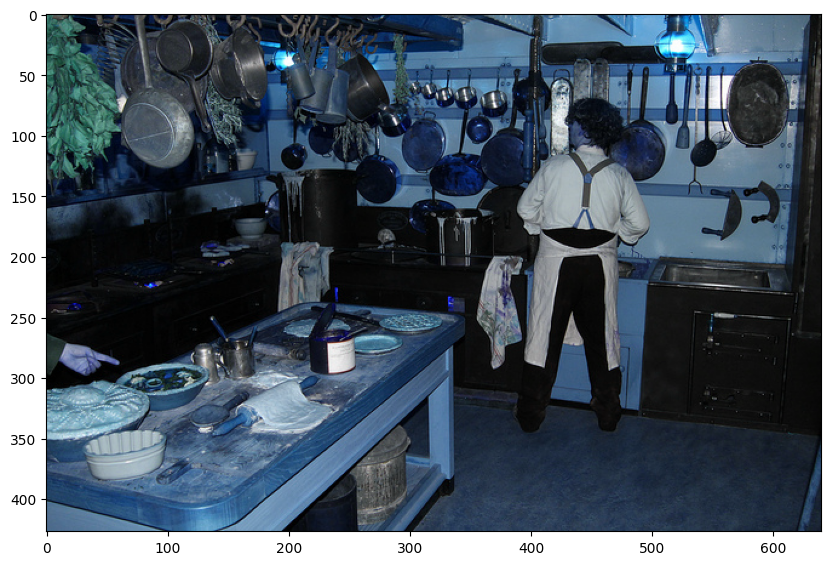

In [78]:
plt.figure(figsize = (10,10))
plt.imshow(img)

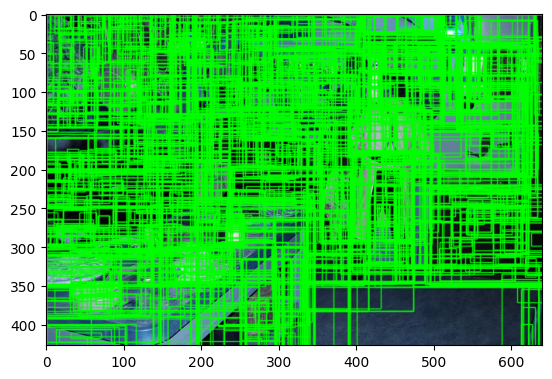

In [79]:
for rect in ss_tmp:
    x, y, w, h = rect
    imOut=cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

In [20]:
def get_iou(a, b, epsilon=1e-5):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
#Generate Train and val
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [80]:
# https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [ ]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(input = vggmodel.input, output = predictions)
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break